## Multi-year UNSEEN ##

Test notebook for figuring out the methodology for exploring how to create a synthetic event set for multi-year wind droughts.

In [1]:
import sys
import pathlib
import platform
# venv_path = "~/nb_envs/bens-nb-env4"
# py_version = platform.python_version_tuple()
# sys.path.append(
#     str(
#         pathlib.Path(
#             f"{venv_path}/lib/python{py_version[0]}.{py_version[1]}/site-packages/"
#         ).expanduser()
#     )
# )

In [2]:
# print(py_version)

In [3]:
# Import local modules
import sys
import os
import glob

# Import third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from xarray import DataArray

In [4]:
# Import my modules
import dictionaries as dic

sys.path.append("/home/users/benhutch/unseen_functions")
import functions as funcs

In [5]:
# import pkg_resources
# import sys

# def print_version(package_name):
#     try:
#         version = pkg_resources.get_distribution(package_name).version
#         print(f"{package_name}: {version}")
#     except pkg_resources.DistributionNotFound:
#         print(f"{package_name}: not found")

# print(f"python: {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
# print_version("cloudpickle")
# print_version("lz4")
# print_version("msgpack")
# print_version("tornado")

In [6]:
# import dask_gateway
# import pathlib

In [7]:
# # Create a connection to dask-gateway.
# gw = dask_gateway.Gateway("https://dask-gateway.jasmin.ac.uk", auth="jupyterhub")

In [8]:
# # Inspect and change the options if required before creating your cluster.
# options = gw.cluster_options()
# options.worker_cores = 2

In [9]:
# clusters = gw.list_clusters()
# if not clusters:
#     cluster = gw.new_cluster(options, shutdown_on_close=False)
# else:
#     cluster = gw.connect(clusters[0].name)
    
# cluster.adapt(minimum=1, maximum=3)

# client = cluster.get_client()

In [10]:
# client.get_versions(check=True)

In [11]:
# client

In [12]:
# ds = xr.tutorial.open_dataset('air_temperature', chunks={'lat': 25, 'lon': 25, 'time': -1})
# ds

In [13]:
# da = ds['air']
# da

In [14]:
# %%time

# da.resample(time='1w').mean('time').std('time').load().plot(figsize=(12, 8))

In [15]:
# import subprocess

# def downgrade_packages(env_dict):
#     scheduler_packages = env_dict['scheduler']['packages']
#     client_packages = env_dict['client']['packages']

#     for package, version in scheduler_packages.items():
#         if package != 'python' and package in client_packages and client_packages[package] != version:
#             print(f"Downgrading {package} to version {version}")
#             subprocess.run(["pip", "install", "--upgrade", f"{package}=={version}"], check=True)

# downgrade_packages(env_dict)

### Exploring gridboxes ###

Checking that the gridboxes are where we expect them to be

In [16]:
# # First, we want to visualise th gridboxes which we might want to use
# # The UK grid box or the north sea grid box

# # Set up the projection
# projection = ccrs.PlateCarree(central_longitude=0)

# # Plot the differences between the two gridboxes
# # Set up the figure
# fig = plt.figure(figsize=(10, 5))
# ax = fig.add_subplot(1, 1, 1, projection=projection)

# # # Include the stock image and coastlines
# ax.stock_img()
# ax.coastlines()

# # Extract the lat and lon data for the UK box
# lon1_uk, lon2_uk = dic.uk_grid['lon1'], dic.uk_grid['lon2']
# lat1_uk, lat2_uk = dic.uk_grid['lat1'], dic.uk_grid['lat2']

# # Extract the lat and lon data for the North Sea box
# lon1_ns, lon2_ns = dic.north_sea_kay['lon1'], dic.north_sea_kay['lon2']
# lat1_ns, lat2_ns = dic.north_sea_kay['lat1'], dic.north_sea_kay['lat2']

# # # Plot these boxes
# # ax.plot([lon1_uk, lon2_uk, lon2_uk, lon1_uk, lon1_uk],
# #         [lat1_uk, lat1_uk, lat2_uk, lat2_uk, lat1_uk],
# #         color='green', linewidth=2, transform=projection, label="UK Clark")

# # # Plot these boxes
# # ax.plot([lon1_ns, lon2_ns, lon2_ns, lon1_ns, lon1_ns],
# #         [lat1_ns, lat1_ns, lat2_ns, lat2_ns, lat1_ns],
# #         color='orange', linewidth=2, transform=projection, label="North Sea Kay")

# # Zoom in on the region
# ax.set_extent([-15, 30, 35, 70], crs=projection)

# # Create a legend
# ax.legend(loc = 'upper left')

# # show the plot
# plt.show()

### Choosing time windows ###

We need to define the time period over which we are looking for wind droughts. Here are three we might consider:

* 1 year (12 months Dec-Nov)
* 3 years (36 months Dec-Nov)
* 5 years (60 months Dec-Nov)

In this first example of 1 year, for 1960 there will be 11 total 12 month time series (DJFMAMJJASON):

* 1 will be the truth (from ERA5) - the weather which actually occurred.
* 10 will be from the decadal prediction system (in this case DePreSys with 10 ensemble members).
    * Here we are assuming November initialisation.

### Extracting the data ###

Model data in this example from HadGEM3-GC31-MM.

Obs data in this example from ERA5.

In [17]:
# # Set up the parameters for extraction
model_var = "tos"
obs_var = "si10"
test_model = "HadGEM3-GC31-MM"
experiment = "dcppA-hindcast"

# test extracting data for daily frequency
frequency="Omon"

In [18]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import *

In [19]:
# %%time

# # Test the new function
member_ds = funcs.load_model_data_xarray(model_variable=model_var,
                                    model=test_model,
                                    experiment=experiment,
                                    start_year=1960,
                                    end_year=1965,
                                    first_fcst_year=1961,
                                    last_fcst_year=1962,
                                    months=[10, 11, 12, 1, 2, 3],
                                    frequency=frequency,
                                    parallel=False,
                                    )

The model path root is badc
Number of unique variant labels: 10
For model: HadGEM3-GC31-MM
First 10 unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
Forming the list of files for each ensemble member for badc
Shape of member files: (10, 6, 12)
Shape of flattened member files: (720,)


Processing init years:   0%|          | 0/6 [00:00<?, ?it/s]

Processing init years: 100%|██████████| 6/6 [05:40<00:00, 56.71s/it]


In [20]:
member_ds

<xarray.Dataset>
Dimensions:             (lead: 125, init: 6, member: 10, bnds: 2, j: 1205,
                         i: 1440, vertices: 4)
Coordinates:
  * lead                (lead) int64 1 2 3 4 5 6 7 ... 120 121 122 123 124 125
  * j                   (j) int32 0 1 2 3 4 5 ... 1199 1200 1201 1202 1203 1204
  * i                   (i) int32 0 1 2 3 4 5 ... 1434 1435 1436 1437 1438 1439
    latitude            (j, i) float32 -89.49 -89.49 -89.49 ... 50.07 50.02 50.0
    longitude           (j, i) float32 73.0 73.25 73.5 73.75 ... 73.0 73.0 73.0
  * member              (member) <U9 'r10i1p1f2' 'r1i1p1f2' ... 'r9i1p1f2'
  * init                (init) int64 1960 1961 1962 1963 1964 1965
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (init, member, lead, bnds) object dask.array<chunksize=(1, 1, 1, 2), meta=np.ndarray>
    vertices_latitude   (init, member, j, i, vertices) float32 dask.array<chunksize=(1, 1, 603, 720, 1), meta=np.ndarray>
    vertices_longitude  (init, member, j, i, vertices) float32 dask.array<chunksize=(1, 1, 603, 720, 1), meta=np.ndarray>
    tos                 (init, member, lead, j, i) float32 dask.array<chunksize=(1, 1, 1, 603, 720), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2020-11-18T15:34:00Z
    ...                     ...
    variable_name:          tos
    variant_label:          r10i1p1f2
    license:                CMIP6 model data produced by Met Office Hadley Ce...
    cmor_version:           3.4.0
    first_month:            1960-11-16 00:00:00
    time_axis_type:         Datetime360Day

In [21]:
# # Apply mask to the netcdf file to get it into 1D
# # first we nned to convert to iris
# member_ds['member'] = member_ds['member'].str[1:-6].astype(int)


In [22]:
# # extract for the variable
# member_ds_var = member_ds[model_var]

In [23]:
# member_cube = member_ds_var.squeeze().to_iris()

In [24]:
# member_cube

In [25]:
# load in the observed monthly mean 10m wind speed data for comparison
ERA5_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/surface_wind_ERA5.nc"

# Set up the start and end years
start_year = 1960
end_year = 2019

# Load in the data
obs = xr.open_mfdataset(
    ERA5_path,
    combine="by_coords",
    parallel=False,
    engine="netcdf4",
)

# Restrict the data to the years we are interested in
obs = obs.sel(time=slice(f"{start_year}-10-01", f"{end_year}-03-31"))

# If expver is present in the observations
if "expver" in obs.coords:
    # Combine the first two expver variables
    obs = obs.sel(expver=1).combine_first(obs.sel(expver=5))


In [26]:
obs

<xarray.Dataset>
Dimensions:    (time: 702, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 1960-10-01 1960-11-01 ... 2019-03-01
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    si10       (time, latitude, longitude) float32 dask.array<chunksize=(702, 721, 1440), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jan 10 16:10:49 2024: cdo selvar,si10 adaptor.mars.inte...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [27]:
# use the iris regridder to regrid the obs data to the same grid as the model data
obs_cube = obs["si10"].squeeze().to_iris()

In [28]:
# import iris
# # regrid the obs data to the model grid
# obs_regridded = obs_cube.regrid(member_cube, iris.analysis.Linear())

In [29]:
# obs_regridded

In [30]:
# member_cube

In [31]:
# # print the min and max lon of the member cube
# print(member_cube.coord('longitude').points.min())
# print(member_cube.coord('longitude').points.max())

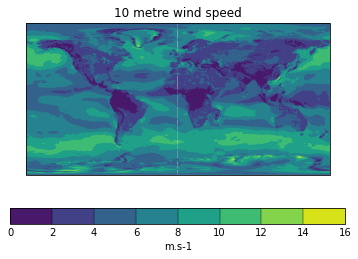

In [32]:
#import iris quickplot
import iris.quickplot as qplt

# quick plot the the obs data
qplt.contourf(obs_cube[0, :, :])

In [33]:
# subset the cube to -180 to 180 and 0 to 90
obs_cube = obs_cube.intersection(longitude=(-180, 180), latitude=(0, 90))

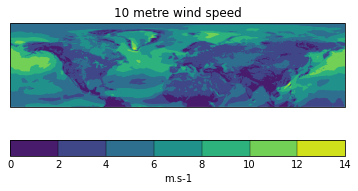

In [34]:
# quick plot the the obs data
qplt.contourf(obs_cube[0, :, :])

In [35]:
# extract the lats and lons from the obs cube
obs_lats = obs_cube.coord('latitude').points
obs_lons = obs_cube.coord('longitude').points

# print the min and max lons
print(obs_lons.min())
print(obs_lons.max())

-180.0
179.75


In [36]:
import iris
import shapely.geometry
import cartopy.io.shapereader as shpreader

# apply the mask
LONS, LATS = iris.analysis.cartography.get_xy_grids(obs_cube[0])
x,y = LONS.flatten(), LATS.flatten()

countries_shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')

COUNTRY = "United Kingdom"


# Shapely treats lons between -180 and 180
# so we need to convert the lons to this
# if there are no lons below 0 then we can just convert the lons
if np.min(x) >= 0:
    raise ValueError("Lons are not between -180 and 180")

MASK_MATRIX_TMP = np.zeros([len(x), 1])
country_shapely = []
for country in shpreader.Reader(countries_shp).records():
    if country.attributes["NAME"][0:14] == COUNTRY:
        print('Found Country ' + COUNTRY)
        country_shapely.append(country.geometry)

# print the min and max lat and lon
print(np.min(x), np.max(x), np.min(y), np.max(y))

# print the min and mx lat and lon of the UK from the shapefile
print(country_shapely[0].bounds)
# print(country_shapely[0].contains(shapely.geometry.Point(0, 0))

# Create a mask for the UK
for i in range(0, len(x)):
    point = shapely.geometry.Point(x[i], y[i])
    if country_shapely[0].contains(point) == True:
        MASK_MATRIX_TMP[i,0] = 1.0

MASK_MATRIX_RESHAPE = np.reshape(MASK_MATRIX_TMP, (np.shape(LONS)))

# if the country is the UK then we want to mask out NI
# to constrain to GB
if COUNTRY == 'United Kingdom':
    lats, lons = np.unique(LATS), np.unique(LONS)
    for i in range(len(lats)):
        for j in range(len(lons)):
            if (lats[i] < 55.3) and (lats[i]  > 54.):
                if (lons[j]) < -5.:  # convert back to -180 to 180 scale
                    # find the corresponding indices in the LATS and LONS arrays
                    indices = np.argwhere((LATS == lats[i]) & (LONS == lons[j]))
                    # set the mask value to 0 at these indices
                    for idx in indices:
                        MASK_MATRIX_RESHAPE[tuple(idx)] = 0.

# print the shape
print(np.shape(MASK_MATRIX_RESHAPE))

Found Country United Kingdom
-180.0 179.75 0.0 90.0
(-13.69131425699993, 49.90961334800005, 1.7711694670000497, 60.84788646000004)
(361, 1440)


In [37]:
# print the sum of the mask
print(np.sum(MASK_MATRIX_RESHAPE))

502.0


Seems like very few grid cells to average over?

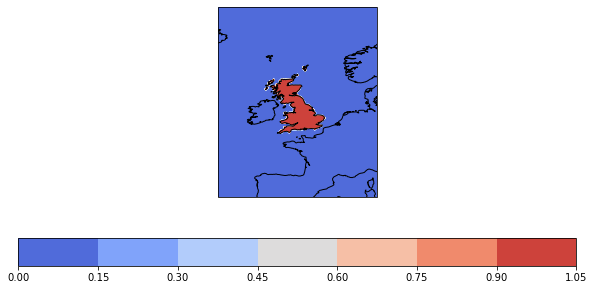

In [38]:
# plot the mask on the map
plt.figure(figsize=(10, 5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()

map = ax.contourf(LONS, LATS, MASK_MATRIX_RESHAPE, transform=ccrs.PlateCarree(), cmap='coolwarm')

# include a colorbar
plt.colorbar(map, orientation='horizontal')

# set the lat and lon limits
ax.set_extent([-15, 10, 40, 70], crs=ccrs.PlateCarree())

plt.show()

In [39]:
# print the min and max of lons
print(np.min(LONS), np.max(LONS))

# print the min and max of lats
print(np.min(LATS), np.max(LATS))

# print the min and max of the mask
print(np.min(MASK_MATRIX_RESHAPE), np.max(MASK_MATRIX_RESHAPE))

-180.0 179.75
0.0 90.0
0.0 1.0


Now fixed - Now we want to apply the country mask to both the model and obs data to start the UNSEEN process specifically over the UK

In [40]:
%%time

# extract the values from the obs data
obs_values = obs_cube.data

# extract the lats
obs_lats = obs_cube.coord('latitude').points
obs_lons = obs_cube.coord('longitude').points

# print the sum of the obs values
print(np.sum(obs_values))

# apply the mask to the obs data
obs_values_masked = obs_values * MASK_MATRIX_RESHAPE

1955343900.0
CPU times: user 8 s, sys: 22 s, total: 30 s
Wall time: 28.2 s


In [41]:
print(np.sum(obs_values_masked))

1594114.7929263115


In [42]:
obs_lons.min()

-180.0

In [43]:
# # convert obs lons to -180 to 180
# obs_lons = obs_lons - 180

In [44]:
# print the min and max of the obs lons
print(obs_lons.min(), obs_lons.max())
print(np.shape(obs_lons))

# print the min and max of the obs lats
print(obs_lats.min(), obs_lats.max())
print(np.shape(obs_lats))

# print the shape of the obs values
print(np.shape(obs_values_masked))# get the indices of the non-zero elements in obs_values_masked


-180.0 179.75
(1440,)
0.0 90.0
(361,)
(702, 361, 1440)


In [45]:
non_zero_indices = np.nonzero(obs_values_masked)

# get the corresponding values in obs_lons and obs_lats
non_zero_lons = obs_lons[non_zero_indices[2]]
non_zero_lats = obs_lats[non_zero_indices[1]]

# print the non-zero longitudes and latitudes
print(non_zero_lons)
print(non_zero_lats)

[-1.5  -1.5  -1.25 ... -5.25 -5.   -3.75]
[60.5  60.25 60.25 ... 50.25 50.25 50.25]


In [46]:
# find the indexes where the obs_values_masked are not zero
idx = np.where(obs_values_masked != 0)

print(idx)

# # print the min and max of the indexes
# # loop over the indexes and print the min and max
# for i in range(len(idx)):
#     print(idx[i].min(), idx[i].max())

(array([  0,   0,   0, ..., 701, 701, 701]), array([118, 119, 119, ..., 159, 159, 159]), array([714, 714, 715, ..., 699, 700, 705]))


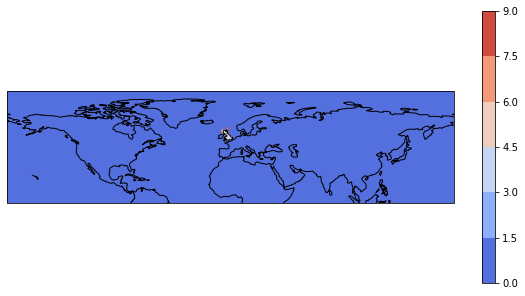

In [47]:
# set up a figure
plt.figure(figsize=(10, 5))

# include the basemap
ax = plt.axes(projection=ccrs.PlateCarree())

# include coastlines
ax.coastlines()

# plot the obs data
plt.contourf(obs_lons, obs_lats, obs_values_masked[0,:,:], cmap='coolwarm')

# # set the lat and lon limits
# ax.set_extent([-15, 10, 40, 70], crs=ccrs.PlateCarree())

# include a colorbar
plt.colorbar()

plt.show()

In [48]:
# anywhere there are zeros in the mask we want to set the obs values to nan
obs_values_masked = np.where(obs_values_masked == 0, np.nan, obs_values_masked)

# take the nanmean over the lat and lon dimensions
obs_values_masked = np.nanmean(obs_values_masked, axis=(1, 2))

In [49]:
from datetime import datetime, timedelta

# set up the reference time
ref_time = datetime(1900, 1, 1)

# set up a dataframe with the obs values and the time
# extract the time points
time_points = obs_cube.coord('time').points

# Convert to datetime
datetimes = [ref_time + timedelta(hours=int(h)) for h in time_points]

# Print the result
for dt in datetimes:
    print(dt)

1960-10-01 00:00:00
1960-11-01 00:00:00
1960-12-01 00:00:00
1961-01-01 00:00:00
1961-02-01 00:00:00
1961-03-01 00:00:00
1961-04-01 00:00:00
1961-05-01 00:00:00
1961-06-01 00:00:00
1961-07-01 00:00:00
1961-08-01 00:00:00
1961-09-01 00:00:00
1961-10-01 00:00:00
1961-11-01 00:00:00
1961-12-01 00:00:00
1962-01-01 00:00:00
1962-02-01 00:00:00
1962-03-01 00:00:00
1962-04-01 00:00:00
1962-05-01 00:00:00
1962-06-01 00:00:00
1962-07-01 00:00:00
1962-08-01 00:00:00
1962-09-01 00:00:00
1962-10-01 00:00:00
1962-11-01 00:00:00
1962-12-01 00:00:00
1963-01-01 00:00:00
1963-02-01 00:00:00
1963-03-01 00:00:00
1963-04-01 00:00:00
1963-05-01 00:00:00
1963-06-01 00:00:00
1963-07-01 00:00:00
1963-08-01 00:00:00
1963-09-01 00:00:00
1963-10-01 00:00:00
1963-11-01 00:00:00
1963-12-01 00:00:00
1964-01-01 00:00:00
1964-02-01 00:00:00
1964-03-01 00:00:00
1964-04-01 00:00:00
1964-05-01 00:00:00
1964-06-01 00:00:00
1964-07-01 00:00:00
1964-08-01 00:00:00
1964-09-01 00:00:00
1964-10-01 00:00:00
1964-11-01 00:00:00


In [50]:
# Set up a dataframe with the obs values and the time as the index
obs_df = pd.DataFrame(obs_values_masked, index=datetimes, columns=['10m_wind_speed_UK'])

In [51]:
obs_df.tail()

,10m_wind_speed_UK
2018-11-01,5.211538
2018-12-01,4.776254
2019-01-01,4.313399
2019-02-01,4.777306
2019-03-01,5.501984


In [52]:
# constrain to only months 10, 11, 12, 1, 2, 3
obs_df = obs_df[obs_df.index.month.isin([10, 11, 12, 1, 2, 3])]

In [53]:
# shift the index back by 3 months and take the annual mean
obs_df_shifted = obs_df.shift(-3).resample('A').mean()

/tmp/ipykernel_25704/4129453483.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  obs_df_shifted = obs_df.shift(-3).resample('A').mean()


In [54]:
obs_df_shifted.tail()

,10m_wind_speed_UK
2015-12-31,5.220619
2016-12-31,4.521414
2017-12-31,5.038342
2018-12-31,4.906784
2019-12-31,NaN


In [55]:
# if any of the rows are NaN then we want to remove them
obs_df_shifted = obs_df_shifted.dropna()

In [56]:
obs_df_shifted.tail()

,10m_wind_speed_UK
2014-12-31,5.199900
2015-12-31,5.220619
2016-12-31,4.521414
2017-12-31,5.038342
2018-12-31,4.906784


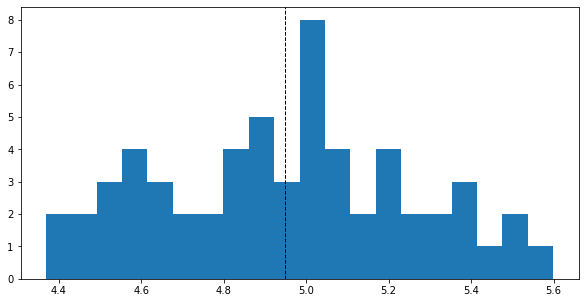

In [57]:
# set up a figure
plt.figure(figsize=(10, 5))

# plot a histogram of the obs values
plt.hist(obs_df_shifted['10m_wind_speed_UK'], bins=20)

# plot the mean as a vertical line
plt.axvline(obs_df_shifted['10m_wind_speed_UK'].mean(), color='k', linestyle='dashed', linewidth=1)

plt.show()

In [59]:
# %%time

# # apply the mask to the member cube
# model_values = member_cube.data

# # apply the mask
# model_values_masked = model_values * MASK_MATRIX_RESHAPE

In [61]:
# # print the shape of the model values masked
# print(np.shape(model_values_masked))

In [60]:
# # extract the lat and lon points fro the model cube
# model_lats = member_cube.coord('latitude').points
# model_lons = member_cube.coord('longitude').points

In [62]:
# # print the min and max of the model lats
# print(np.min(model_lats), np.max(model_lats))

# # print the min and max of the model lons
# print(np.min(model_lons), np.max(model_lons))

In [63]:
# # convert model lons to -180 to 180
# model_lons = model_lons - 180

In [64]:
# # set up a figure
# plt.figure(figsize=(10, 5))

# # include the basemap
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

# # include coastlines
# ax.coastlines()

# # plot the obs data
# plt.contourf(model_lons, model_lats, model_values_masked[0,0,0,:,:], cmap='coolwarm')

# # set the lat and lon limits
# ax.set_extent([-15, 10, 40, 70], crs=ccrs.PlateCarree())

# # include a colorbar
# plt.colorbar()

# plt.show()

In [65]:
# # anywhere there are zeros in the mask we want to set the obs values to nan
# model_values_masked = np.where(model_values_masked == 0, np.nan, model_values_masked)

# # take the nanmean over the lat and lon dimensions
# model_values_masked = np.nanmean(model_values_masked, axis=(3, 4))

In [66]:
# # print the shape of the model values masked
# print(np.shape(model_values_masked))

In [67]:
# # extract the init values from the cube
# init_years = member_cube.coord('init').points

# # extract the member values from the cube
# members = member_cube.coord('member').points

# # extract the leads from the cube
# leads = member_cube.coord('lead').points

In [68]:
# # Set up an empty dataframe
# model_df = pd.DataFrame()

# # loop over the init years and members and leads
# for i in range(len(init_years)):
#     for m in range(len(members)):
#         for l in range(len(leads)):
#             # extract the data
#             data = model_values_masked[i, m, l]

#             # add these to the dataframe
#             model_df_this = pd.DataFrame(
#                 {
#                     'init_year': [init_years[i]],
#                     'member': [members[m]],
#                     'lead': [leads[l]],
#                     'data': [data]
#                 }
#             )

#             model_df = pd.concat([model_df, model_df_this])

In [112]:
# load data for this model and obs
# for the first NDJFM - leads 1-5
# set up the directory
dfs_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/"

# Extract the data for the UK between 1960 and 2018 for the model tas and sfcWind
model_sfcWind_fname = "HadGEM3-GC31-MM_sfcWind_Norway_ONDJFM_1960_2018_dcppA-hindcast_Amon.csv"
model_tas_fname = "HadGEM3-GC31-MM_tas_Norway_ONDJFM_1960_2018_dcppA-hindcast_Amon.csv"

# Extract the data for the UK between 1960 and 2018 for the obs
obs_sfcWind_fname = "ERA5_obs_sfcWind_Norway_ONDJFM_1960_2018.csv"
obs_tas_fname = "ERA5_obs_tas_Norway_ONDJFM_1960_2018.csv"

In [113]:
# load the model data
model_sfcWind_df = pd.read_csv(os.path.join(dfs_dir, model_sfcWind_fname))
model_tas_df = pd.read_csv(os.path.join(dfs_dir, model_tas_fname))

# rename data to the variable
model_sfcWind_df = model_sfcWind_df.rename(columns={'data': 'sfcWind'})
model_tas_df = model_tas_df.rename(columns={'data': 'tas'})

# merge the two dataframes
model_df = model_sfcWind_df.merge(model_tas_df, on=['init_year', 'member', 'lead'])

In [114]:
# print the unique model_df leads
print(model_df['lead'].unique())

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125]


In [115]:
# create a new list of leads
leads = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [116]:
# extract the first NDJFM for fidelity testing
# create a new cf to calculate the means over the ONDJFM
df_new = pd.DataFrame()

# loop over the unique init years and members in model_df
for init_year in model_df['init_year'].unique():
    for member in model_df['member'].unique():
        for l in leads:
            # extract the model data
            model_data = model_df[(model_df['init_year'] == init_year) & (model_df['member'] == member)]

            # subset to lead values [(12*l) ,(12*l) + 1, (12*l) + 2, (12*l) + 3, (12*l) + 4, (12*l) + 5]
            # first complete NDJFM season
            model_data = model_data[model_data['lead'].isin([(12*l) ,(12*l) + 1, (12*l) + 2, (12*l) + 3, (12*l) + 4, (12*l) + 5])]

            mean_tas = model_data['tas'].mean()
            mean_sfcWind = model_data['sfcWind'].mean()

            # create a dataframe this
            model_data_this = pd.DataFrame(
                {
                    'init_year': [init_year],
                    'member': [member],
                    'lead': [l],
                    'tas': [mean_tas],
                    'sfcWind': [mean_sfcWind]
                }
            )

            df_new = pd.concat([df_new, model_data_this])


In [117]:
df_new.head()

,init_year,member,lead,tas,sfcWind
0,1960,10,1,264.068835,3.055735
0,1960,10,2,264.221898,3.048288
0,1960,10,3,262.345046,3.188626
0,1960,10,4,262.838818,3.048564
0,1960,10,5,257.876639,2.552583


In [118]:
# check that the obs files exist
if not os.path.exists(os.path.join(dfs_dir, obs_sfcWind_fname)):
    raise ValueError("Obs sfcWind file does not exist")

if not os.path.exists(os.path.join(dfs_dir, obs_tas_fname)):
    raise ValueError("Obs tas file does not exist")

In [119]:
# Extract NDJFM for the obs data
df_ERA5_tas = pd.read_csv(os.path.join(dfs_dir, obs_tas_fname))
df_ERA5_sfcWind = pd.read_csv(os.path.join(dfs_dir, obs_sfcWind_fname))

# print(df_ERA5_tas.head())

# sys.exit()

# reset the names from obs to the variable
df_ERA5_tas = df_ERA5_tas.rename(columns={'obs': 'tas'})
df_ERA5_sfcWind = df_ERA5_sfcWind.rename(columns={'obs': 'sfcWind'})

# merge on time
df_ERA5 = pd.merge(df_ERA5_tas, df_ERA5_sfcWind, on=['time'])

# make sure that time is datetime
df_ERA5['time'] = pd.to_datetime(df_ERA5['time'])

# set the index to time
df_ERA5.set_index('time', inplace=True)

# Subset to the months NDJFM or 11, 12, 1, 2, 3
df_ERA5 = df_ERA5[df_ERA5.index.month.isin([10, 11, 12, 1, 2, 3])]

# shift the index back by 3 months and take the annual mean
df_ERA5_shifted = df_ERA5.shift(-3, freq='M').resample('A').mean()

/tmp/ipykernel_25704/3967036622.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_ERA5_shifted = df_ERA5.shift(-3, freq='M').resample('A').mean()
/tmp/ipykernel_25704/3967036622.py:26: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_ERA5_shifted = df_ERA5.shift(-3, freq='M').resample('A').mean()


In [120]:
df_ERA5_shifted.head()

,tas,sfcWind
time,,
1960-12-31,263.766465,3.201209
1961-12-31,263.363169,3.392894
1962-12-31,261.331766,3.272926
1963-12-31,263.729777,3.245119
1964-12-31,263.595179,3.473496


In [121]:
# reset the index for df_ERA5_shifted
df_ERA5_shifted.reset_index(inplace=True)

In [122]:
df_new.head()

,init_year,member,lead,tas,sfcWind
0,1960,10,1,264.068835,3.055735
0,1960,10,2,264.221898,3.048288
0,1960,10,3,262.345046,3.188626
0,1960,10,4,262.838818,3.048564
0,1960,10,5,257.876639,2.552583


Calculating bootstrap statistics: 100%|██████████| 10000/10000 [03:56<00:00, 42.24it/s]


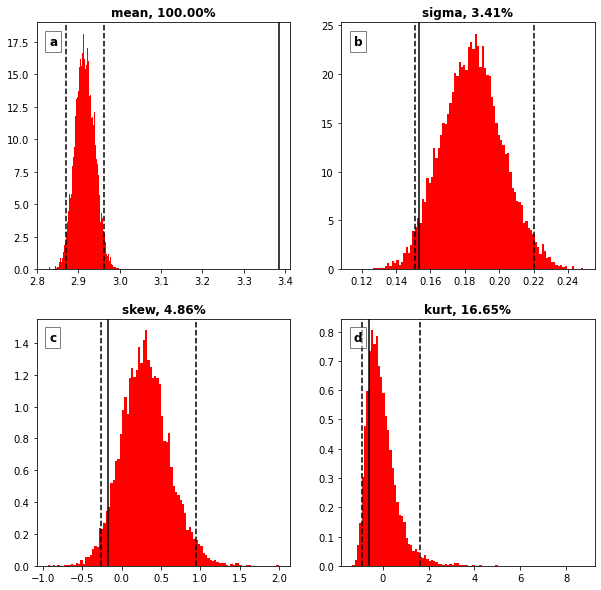

In [124]:
# plot the fidelity
funcs.plot_fidelity(
    obs_df=df_ERA5_shifted,
    model_df=df_new,
    obs_val_name='sfcWind',
    model_val_name='sfcWind',
    obs_time_name='time',
    model_time_name='init_year',
    model_lead_name="lead",
    nboot=10000,
)

Perhaps a simple example first of all - consider the first complete ONDJFM in the model data.

In [114]:
# create a new df
model_df_new = pd.DataFrame()

# loop over the unique init years and members in model_df
for init_year in model_df['init_year'].unique():
    for member in model_df['member'].unique():
        # extract the model data
        model_data = model_df[(model_df['init_year'] == init_year) & (model_df['member'] == member)]

        # subset to lead values [12, 13, 14, 15, 16, 17] and take the mean
        # first complete ONDJFM season
        model_data = model_data[model_data['lead'].isin([12, 13, 14, 15, 16, 17])]

        mean_data = model_data['data'].mean()

        # create a dataframe this
        model_data_this = pd.DataFrame(
            {
                'init_year': [init_year],
                'member': [member],
                'data': [mean_data]
            }
        )

        model_df_new = pd.concat([model_df_new, model_data_this])

In [118]:
model_df_new.head()

,init_year,member,data
0,1960,10,10.428748
0,1960,1,10.345117
0,1960,2,10.200590
0,1960,3,10.097336
0,1960,4,10.567812


In [150]:
obs_df_shifted_time = obs_df_shifted.reset_index()

In [152]:
# drop the nans from the obs df
obs_df_shifted_time = obs_df_shifted_time.dropna()

In [153]:
obs_df_shifted_time['10m_wind_speed_UK']

0    9.502781
1    9.066864
2    8.589039
3    8.642107
4    9.308294
5    8.829500
Name: 10m_wind_speed_UK, dtype: float64

In [123]:
# reload the functions
import importlib

importlib.reload(sys.modules['functions'])

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

In [129]:
from scipy import stats

stats.skew(obs_df_shifted_time['10m_wind_speed_UK'])

-0.0040505934479714055

Calculating bootstrap statistics: 100%|██████████| 1000/1000 [00:02<00:00, 488.15it/s]


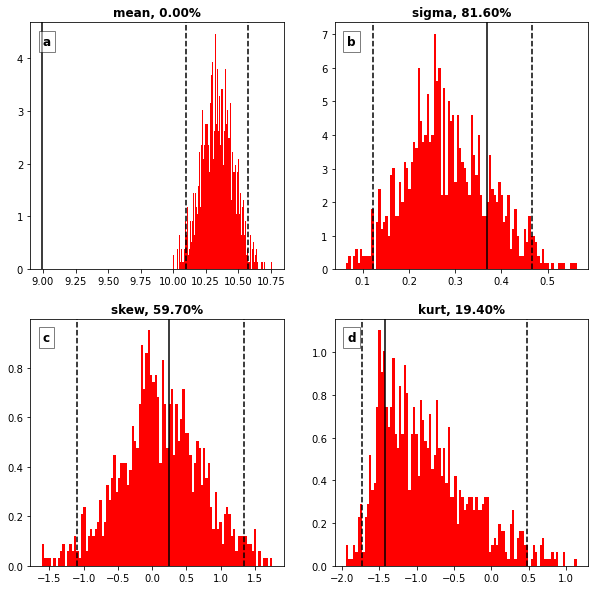

In [154]:
# plot the fidelity
funcs.plot_fidelity(
    obs_df=obs_df_shifted_time,
    model_df=model_df_new,
    obs_val_name='10m_wind_speed_UK',
    model_val_name='data',
    obs_time_name='index',
    model_time_name='init_year',
    model_lead_name=None,
    nboot=1000, # testing run
)

In [21]:
# single_file = "/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r1i1p1f2/day/tas/gn/files/d20200417/tas_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_19601101-19601230.nc"

# # load single file
# ds_single = xr.open_dataset(single_file)

In [22]:
# ds_single

In [23]:
# %%time

# # Test loading obs data
# # File = surface_wind_ERA5.nc
# # Directory = /home/users/benhutch/ERA5
# obs_df = funcs.load_regrid_obs(
#     model_ds=ds_single,
#     obs_variable=obs_var,
#     obs_path="/home/users/benhutch/ERA5/surface_wind_ERA5.nc",
#     start_year=1961,
#     end_year=2014,
#     months=[10, 11, 12, 1, 2, 3],
#     grid=dic.uk_grid,
# )

In [24]:
# obs_df.head()

In [25]:
# # rename value to sfcWind_UK_obs
# obs_df.rename(columns={"value": "sfcWind_UK_obs"}, inplace=True)

In [26]:
# obs_df.head()

In [27]:
# # When you are done and whish to release your cluster:
# cluster.shutdown()

In [28]:
# %%time

# # Regrid the dataset
# rg_ds = funcs.regrid_ds(
#     ds=member_ds,
#     variable="sfcWind",
# )

In [29]:
# print(rg_ds["lon"].min().values)
# print(rg_ds["lon"].max().values)
# print(rg_ds["lat"].min().values)
# print(rg_ds["lat"].max().values)

In [30]:
# import importlib

# importlib.reload(sys.modules['functions'])

# import functions as funcs

In [31]:
# %%time

# # Select the UK grid
# uk_ds = funcs.select_gridbox(
#     ds=rg_ds,
#     grid=dic.uk_grid,
# )

In [32]:
# import importlib

# importlib.reload(sys.modules['functions'])

# import functions as funcs

In [33]:
# print(uk_ds)

In [34]:
# # test the new function
# dates = funcs.select_months(
#     ds=uk_ds,
#     months=[10, 11, 12, 1, 2, 3],
#     first_day="1961-11-01",
#     first_time="12:00:00",
#     frequency=frequency,
# )

In [35]:
# dates

In [36]:
# # first month (1) = 1961-11-16 00:00:00
# # first day (1) = 1961-11-01 12:00:00
# # frequency = "day"
# # time_axis_type : Datetime360Day
# ds = funcs.lead_time_avg(
#     ds=uk_ds,
#     months=[10, 11, 12, 1, 2, 3],
#     first_month="1961-11-16"
# )

In [37]:
# ds

In [38]:
%%time

# set up the fname and directory
fname="test-uk-wind2.csv"
directory="/home/users/benhutch/unseen_multi_year"


# Set up the fpath
fpath=os.path.join(directory,fname)

# # Set a name
# ds.name = "sfcWind_UK"

# # save as a csv
# ds.to_dataframe().to_csv(fpath)

CPU times: user 25 µs, sys: 12 µs, total: 37 µs
Wall time: 41 µs


In [39]:
df = pd.read_csv(fpath)

In [40]:
df.head()

,lead,init,member,height,sfcWind_UK
0,1,1961,r10i1p1f2,10.0,8.422969
1,1,1961,r1i1p1f2,10.0,8.427586
2,1,1961,r2i1p1f2,10.0,7.839721
3,1,1961,r3i1p1f2,10.0,7.730560
4,1,1961,r4i1p1f2,10.0,7.879578


In [41]:
# drop height from the dataframe
df = df.drop('height', axis=1)

In [42]:
df.head()

,lead,init,member,sfcWind_UK
0,1,1961,r10i1p1f2,8.422969
1,1,1961,r1i1p1f2,8.427586
2,1,1961,r2i1p1f2,7.839721
3,1,1961,r3i1p1f2,7.730560
4,1,1961,r4i1p1f2,7.879578


In [47]:
# limit df to member r1i1p1f2 and init 1961
df_subset = df[(df['lead'] == 1)]

In [48]:
df_subset

,lead,init,member,sfcWind_UK
0,1,1961,r10i1p1f2,8.422969
1,1,1961,r1i1p1f2,8.427586
2,1,1961,r2i1p1f2,7.839721
3,1,1961,r3i1p1f2,7.730560
4,1,1961,r4i1p1f2,7.879578
...,...,...,...,...
535,1,2014,r5i1p1f2,7.749636
536,1,2014,r6i1p1f2,8.131401
537,1,2014,r7i1p1f2,8.702769
538,1,2014,r8i1p1f2,7.712269


In [49]:
# Select an ensemble member
df_subset_r1 = df_subset[df_subset['member'] == 'r1i1p1f2']

In [50]:
# select another ensemble member
df_subset_r2 = df_subset[df_subset['member'] == 'r2i1p1f2']

In [53]:
df_subset_r1

,lead,init,member,sfcWind_UK
1,1,1961,r1i1p1f2,8.427586
11,1,1962,r1i1p1f2,8.286530
21,1,1963,r1i1p1f2,8.470258
31,1,1964,r1i1p1f2,8.166554
41,1,1965,r1i1p1f2,8.356259
51,1,1966,r1i1p1f2,8.001434
61,1,1967,r1i1p1f2,7.738892
71,1,1968,r1i1p1f2,8.000023
81,1,1969,r1i1p1f2,8.358836
91,1,1970,r1i1p1f2,7.778216


In [54]:
df_subset_r2

,lead,init,member,sfcWind_UK
2,1,1961,r2i1p1f2,7.839721
12,1,1962,r2i1p1f2,8.736528
22,1,1963,r2i1p1f2,7.878740
32,1,1964,r2i1p1f2,8.303681
42,1,1965,r2i1p1f2,7.878453
52,1,1966,r2i1p1f2,7.888980
62,1,1967,r2i1p1f2,7.949926
72,1,1968,r2i1p1f2,8.445631
82,1,1969,r2i1p1f2,8.203076
92,1,1970,r2i1p1f2,8.083932


In [55]:
import importlib

importlib.reload(sys.modules['functions'])

import functions as funcs

In [ ]:
# # Plot a histogram for all of the model data
# plt.hist(df['sfcWind_UK'], bins=50, alpha=0.5, label='model')

In [ ]:
# # plot the obs data
# plt.hist(obs_df['sfcWind_UK_obs'], bins=50, alpha=0.5, label='obs')

In [ ]:
# # Test the function for plotting the GEV distribution
# rvs = funcs.plot_gev_return_values(
#     obs_df=obs_df,
#     model_df=df,
#     obs_val_name="sfcWind_UK_obs",
#     model_val_name="sfcWind_UK",
#     ylabel="Wind Speed (m/s)",
# )

In [56]:
# Test the function for plotting events
funcs.plot_events_ts(
    obs_df=obs_df,
    model_df=df,
    obs_val_name="sfcWind_UK_obs",
    model_val_name="sfcWind_UK",
    ylabel="10m wind speed (m/s)",
    delta_shift_bias=True, # apply a delta shift to the mean
    figsize=(12, 6),
)

NameError: name 'obs_df' is not defined

In [ ]:
# # Plot the events using boxplots
# funcs.plot_events_ts_bp(
#     obs_df=obs_df,
#     model_df=df,
#     obs_val_name="sfcWind_UK_obs",
#     model_val_name="sfcWind_UK",
#     ylabel="10m wind speed (m/s)",
#     delta_shift_bias=True, # apply a delta shift to the mean
#     figsize=(12, 6),
# )

In [ ]:
# Plot the fidelity
funcs.plot_fidelity(
    obs_df=obs_df,
    model_df=df,
    obs_val_name="sfcWind_UK_obs",
    model_val_name="sfcWind_UK",
    nboot=10000,
)

In [57]:
# Test the independence function
corr_matrix = funcs.independence_test(
    ensemble=df,
    members=df['member'].unique(),
    n_leads=len(df['lead'].unique()),
    var_name="sfcWind_UK",
    detrend=True,
)

Calculating correlations:  10%|█         | 1/10 [00:00<00:00,  9.90it/s]

Calculating correlations for lead 1
Calculating correlations for lead 2
Calculating correlations for lead 3


Calculating correlations:  50%|█████     | 5/10 [00:00<00:00, 13.01it/s]

Calculating correlations for lead 4
Calculating correlations for lead 5
Calculating correlations for lead 6


Calculating correlations:  70%|███████   | 7/10 [00:00<00:00, 13.47it/s]

Calculating correlations for lead 7
Calculating correlations for lead 8
Calculating correlations for lead 9


Calculating correlations: 100%|██████████| 10/10 [00:00<00:00, 13.18it/s]

Calculating correlations for lead 10


In [ ]:
(df['lead'].unique())

In [ ]:
# Why is the first one all NaN's and zeros?
first_lead_corr_m = corr_matrix[-1]

In [ ]:
first_lead_corr_m.shape

In [ ]:
second_lead_corr_m = corr_matrix[1]

In [ ]:
second_lead_corr_m

In [ ]:
# flatten the data
flat_second_lead = second_lead_corr_m.flatten()

# plot the histogram
plt.hist(flat_second_lead, bins=10)

# Show the plot
plt.show()

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

import functions as funcs

In [ ]:
corr_matrix[0]

In [ ]:
%%time

# Plot the boxplots
funcs.plot_independence(
    corr_matrix=corr_matrix,
)

10it [00:00, 65.90it/s]


CPU times: user 218 ms, sys: 158 ms, total: 376 ms
Wall time: 407 ms


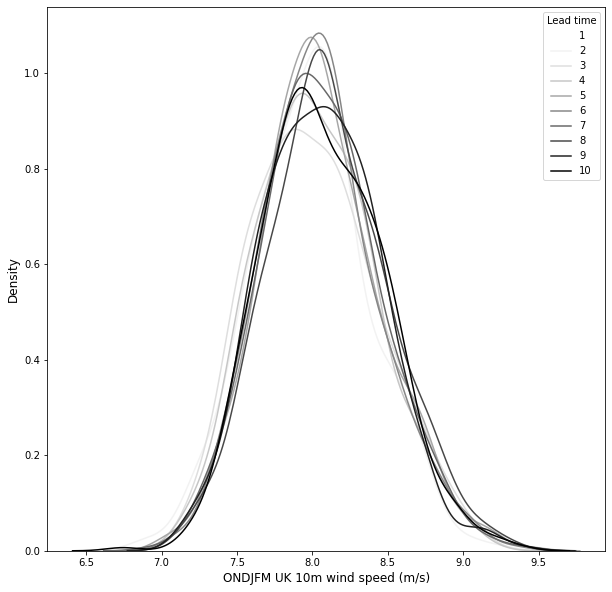

In [58]:
%%time

# Plot the density distribution
funcs.stability_density(
    ensemble=df,
    var_name="sfcWind_UK",
    label="ONDJFM UK 10m wind speed (m/s)",
    cmap="Greys",
)

In [ ]:
df

The pooled length is 5400
The lead length is 540


Performing bootstrapping: 100%|██████████| 10000/10000 [00:00<00:00, 32637.88it/s]
10it [00:00, 47.42it/s]


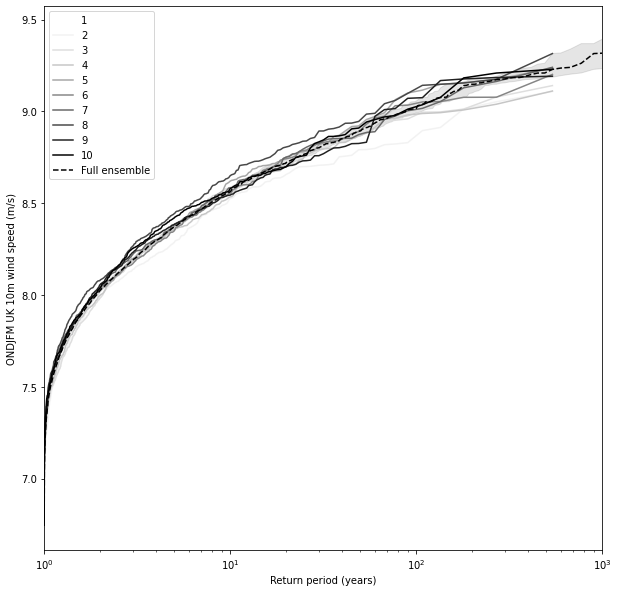

CPU times: user 1min 6s, sys: 1.43 s, total: 1min 7s
Wall time: 1min 8s


In [59]:
%%time

# test the model stability boot function
df_quantiles = funcs.model_stability_boot(
    ensemble=df,
    var_name="sfcWind_UK",
    label="ONDJFM UK 10m wind speed (m/s)",
    nboot=10000,
    cmap="Greys",
)

In [ ]:
df_quantiles.head()

In [ ]:
df_corr = funcs.plot_independence_sb(
    corr_matrix=corr_matrix,
)

In [ ]:
funcs.plot_independence_violin(
    corr_matrix=corr_matrix,
)

In [ ]:
funcs.plot_independence_pd(
    corr_matrix=corr_matrix,
)

In [ ]:
# Test the spatial smoothing function 
lat_res = (ds['lat'].max() - ds['lat'].min())/(ds['lat'].count()-1.)

# Calculate the resolution of the data - lon
lon_res = (ds['lon'].max() - ds['lon'].min())/(ds['lon'].count()-1.)

In [ ]:
lat_res = lat_res.values
lon_res = lon_res.values

In [ ]:
print(lat_res)
print(lon_res)

In [ ]:
import xesmf as xe

# Set up the output grid
ds_out = xe.util.grid_2d(-180.0, 180.0, lon_res, -90.0, 90.0, lat_res)

In [ ]:
# set up the regridder
regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True)

In [ ]:
# Apply this to sfcWind
ds

In [ ]:
sfcWind_regrid = regridder(ds['sfcWind'])

In [ ]:
sfcWind_regrid

In [ ]:
ds['sfcWind'].isel(init=0, member=0, lead=0).plot()

In [ ]:
sfcWind_regrid.isel(init=0, member=0, lead=0).plot()

In [ ]:
sfcWind_regrid

In [ ]:
# test selecting the UK grid
grid = dic.uk_grid

lon1, lon2, lat1, lat2 = grid['lon1'], grid['lon2'], grid['lat1'], grid['lat2']

In [ ]:
# sfcWind_regrid = sfcWind_regrid.sel(lat=slice(lat1, lat2),
#             lon=slice(lon1, lon2)).mean(dim=('lat','lon'))

sfcWind_regrid["lat"]

In [ ]:
mask = (sfcWind_regrid['lat'] > lat1) & (sfcWind_regrid['lat'] < lat2) & (sfcWind_regrid['lon'] > lon1) & (sfcWind_regrid['lon'] < lon2)
ds_masked = sfcWind_regrid.where(mask)
mean_ds = ds_masked.mean(dim=('y','x'))

In [ ]:
ds_masked.isel(init=0, member=0, lead=0).plot()

In [ ]:
mean_ds

In [ ]:
d_lon_lat_kws_hadgem =  {'lat': lat_res, 'lon': lon_res}

In [ ]:
# regrid_ds = climpred.smoothing.spatial_smoothing_xesmf(
#     ds, 
#     d_lon_lat_kws={'lat': 5, 'lon': 5}, 
#     method='bilinear', 
#     periodic=False, 
#     filename=None, 
#     reuse_weights=False, 
#     tsmooth_kws=None, 
#     how=None
# )

In [ ]:
regrid_ds

In [ ]:
import matplotlib.pyplot as plt

# Select the data for the first init member and lead
data = ds.isel(init=0, member=0, lead=0)


In [ ]:
data

In [ ]:
data["sfcWind"].plot()

In [ ]:
# Look at the data
len(member_files[0])

In [ ]:
flat_list = [item for sublist in member_files for item in sublist]

In [ ]:
flat_list[0]

In [ ]:
print((variant_labels))

In [ ]:
# test_file = "/work/scratch-nopw2/benhutch/sfcWind/HadGEM3-GC31-MM/global/all_forecast_years/ONDJFM/outputs/all-years-ONDJFM-global-sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_196011-197103.nc"

# ds = xr.open_dataset(test_file)

In [ ]:
ds

In [ ]:
# Print the values
print(model_data.sfcWind.values)

In [ ]:
# test the read_data function
model_data = load_model_data(model_variable=model_var,
                            model=test_model,
                            experiment=experiment,
                            start_year=1961,
                            end_year=2014,
                            avg_period=2,
                            grid=dic.uk_grid)

In [ ]:
print(model_data.shape)

In [ ]:
# Take the mean of the model data over the months axis
model_data_year = model_data.mean(axis=2)

# # Print the new shape
print(model_data_year.shape)

# Winter 1 data
winter1_data = model_data[:, :, 0:4].mean(axis=2)

# summer data
summer_data = model_data[:, :, 4:10].mean(axis=2)

# winter 2 data
winter2_data = model_data[:, :, 10:].mean(axis=2)

# Print the shapes of the new data
print(winter1_data.shape)

# Print the shapes of the new data
print(summer_data.shape)

# Print the shapes of the new data
print(winter2_data.shape)

In [ ]:
# Get the data including the months, no mean
winter1_data_months = model_data[:, :, 0:4]
summer_data_months = model_data[:, :, 4:10]
winter2_data_months = model_data[:, :, 10:]
year_data_months = model_data

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import load_model_data, model_stats_bs

In [ ]:
# test the bootstrapping function
stats_dict_year = model_stats_bs(model=year_data_months.mean(axis=2),
                            nboot=10000)

In [ ]:
# test the bootstrapping function
stats_dict_winter1 = model_stats_bs(model=winter1_data_months.mean(axis=2),
                            nboot=10000)

In [ ]:
# test the bootstrapping function
stats_dict_summer = model_stats_bs(model=summer_data_months.mean(axis=2),
                            nboot=10000)

In [ ]:
# test the bootstrapping function
stats_dict_winter2 = model_stats_bs(model=winter2_data_months.mean(axis=2),
                            nboot=10000)

In [ ]:
# print(stats_dict)

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import load_model_data, load_obs_data, calculate_obs_stats

In [ ]:
obs_data = load_obs_data(obs_variable=obs_var,
                         regrid_obs_path="/home/users/benhutch/ERA5/surface_wind_ERA5_regrid_HadGEM.nc",
                        start_year=1961,
                        end_year=2014,
                        avg_period=2,
                        grid=dic.uk_grid)

In [ ]:
# Extract and print the obs years
obs_years = obs_data[1]

# print the shape of the obs data
print(obs_years.shape)
print(obs_years)

In [ ]:
# Extract the obs data for the different seasons
obs_data_year = obs_data[0]
obs_data_winter1 = obs_data[0][:, 0:4]
obs_data_summer = obs_data[0][:, 4:10]
obs_data_winter2 = obs_data[0][:, 10:]

In [ ]:
# Calculate the stats
obs_stats_year = calculate_obs_stats(obs_data=obs_data_year,
                                start_year=1960,
                                end_year=2018,
                                avg_period=1,
                                grid=dic.uk_grid)

obs_stats_winter1 = calculate_obs_stats(obs_data=obs_data_winter1,
                                start_year=1960,
                                end_year=2018,
                                avg_period=1,
                                grid=dic.uk_grid)

obs_stats_summer = calculate_obs_stats(obs_data=obs_data_summer,
                                start_year=1960,
                                end_year=2018,
                                avg_period=1,
                                grid=dic.uk_grid)

obs_stats_winter2 = calculate_obs_stats(obs_data=obs_data_winter2,
                                start_year=1960,
                                end_year=2018,
                                avg_period=1,
                                grid=dic.uk_grid)

In [ ]:
print(obs_stats_year)

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import load_model_data, load_obs_data, calculate_obs_stats, \
    plot_moments 

In [ ]:
# # Plot the moments of the distribution
# plot_moments(model_stats=stats_dict,
#              obs_stats=obs_stats,)

In [ ]:
# Plot the moments of the distribution for the different seasons
plot_moments(model_stats=stats_dict_year,
             obs_stats=obs_stats_year)

In [ ]:
# Plot the moments of the distribution for the different seasons
plot_moments(model_stats=stats_dict_winter1,
             obs_stats=obs_stats_winter1)

In [ ]:
# Plot the moments of the distribution for the summer
plot_moments(model_stats=stats_dict_summer,
             obs_stats=obs_stats_summer)

In [ ]:
# Plot the moments of the distribution for winter2
plot_moments(model_stats=stats_dict_winter2,
             obs_stats=obs_stats_winter2)

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import load_model_data, load_obs_data, calculate_obs_stats, \
    plot_moments, plot_distribution

In [ ]:
plot_distribution(model_data=model_data_year,
                  obs_data=obs_data_year,)

In [ ]:
# Plot the distribution of the winter 1 data
plot_distribution(model_data=winter1_data,
                  obs_data=obs_data_winter1,)

In [ ]:
# Plot the distribution of the summer data
plot_distribution(model_data=summer_data,
                  obs_data=obs_data_summer,)

In [ ]:
# PLot the distribution of the winter 2 data
plot_distribution(model_data=winter2_data,
                  obs_data=obs_data_winter2,)

In [ ]:
# # Take the average over the time period
# # i.e. the 2th axis
# model_data_ann_mean = model_data.mean(axis=2)

# print(model_data_ann_mean)

# print(model_data_ann_mean.shape)

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import *

In [ ]:
# Plot the year events
plot_events(model_data=model_data_year,
            obs_data=obs_data_year,
            obs_stats=obs_stats_year,
            start_year=1960,
            end_year=2018,
            figsize_y=5,)

In [ ]:
# Plot the winter 1 events
plot_events(model_data=winter1_data,
            obs_data=obs_data_winter1,
            obs_stats=obs_stats_winter1,
            start_year=1960,
            end_year=2018,
            figsize_y=5,)

In [ ]:
# Plot the summer events
plot_events(model_data=summer_data,
            obs_data=obs_data_summer,
            obs_stats=obs_stats_summer,
            start_year=1960,
            end_year=2018,
            figsize_y=5,)

In [ ]:
# Plot the winter2 events
plot_events(model_data=winter2_data,
            obs_data=obs_data_winter2,
            obs_stats=obs_stats_winter2,
            start_year=1960,
            end_year=2018,
            figsize_y=5,)

In [ ]:
# Calculate the bias
# the difference in the means between the model and the observations
bias = np.mean(model_data_ann_mean.flatten()) - obs_stats['mean']

print(bias)

# Remove the bias from the model data
model_data_ann_mean_bias = model_data_ann_mean - bias

In [ ]:
# create an array of years
years = np.arange(1960, 2019)

# Set up a figure
fig = plt.figure(figsize=(10, 5))

print("Plotting model data shape: ", model_data_ann_mean_bias.shape)

# Plot the data
# Plot the data
for i in range(min(model_data_ann_mean_bias.shape[1], model_data_ann_mean_bias.shape[0] - 1)):
    print("Plotting model data for ensemble member: ", i)
    
    # Separate data into two groups based on the condition
    below_20th = model_data_ann_mean_bias[:, i] < obs_stats['min_20']
    above_20th = ~below_20th
    
    # Plot points below the 20th percentile with a label
    plt.scatter(years[below_20th], model_data_ann_mean_bias[below_20th, i],
                color='blue', alpha=0.8, label='model wind drought' if i == 0 else None)
    
    # Plot points above the 20th percentile without a label
    plt.scatter(years[above_20th], model_data_ann_mean_bias[above_20th, i],
                color='grey', alpha=0.8, label='HadGEM3-GC31-MM' if i == 0 else None)

# plot the obs
plt.scatter(years, obs_data.mean(axis=1), label='ERA5', color='black')

# Plot the 20th percentile
# as a horizontal line
plt.axhline(y=obs_stats['min_20'],
            color='black', linestyle='-')

# Plot the min
# as a horizontal line
plt.axhline(y=obs_stats['min'],
            color='black', linestyle='--')

# Add a legend
plt.legend(loc='upper left')

# Add axis labels
plt.xlabel("Year")

# Add a title
plt.title("Annual mean " + model_var)

# Show the plot
plt.show()

In [ ]:
import seaborn as sns

# Assemble the data into a continuous array
model_data_ann_mean_flat = model_data_ann_mean.flatten()

# Plot the distribution of the data
sns.distplot(model_data_ann_mean_flat, label="model")

# # Plot the mean as a vertical line
# plt.axvline(x=model_data_ann_mean_flat.mean(),
#             color='black', linestyle='-')

# Plot the distribution of the observations
sns.distplot(obs_data.mean(axis=1), label="obs")

# # Plot the mean as a vertical line
# plt.axvline(x=obs_stats['mean'],
#             color='black', linestyle='--')

# Include a textbox with the sample size
plt.text(0.05, 0.85,f"model_n = {model_data_ann_mean_flat.shape[0]}\nobs_n = {obs_data.shape[0]}",
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Add a legend
plt.legend()

# Add a title
plt.title("Annual mean " + model_var + " distribution")

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import load_model_data, load_obs_data, calculate_obs_stats, plot_events

In [ ]:
# load model data but for 3 year averages
model_data_3yr_mean = load_model_data(model_variable=model_var,
                            model=test_model,
                            experiment=experiment,
                            start_year=1960,
                            end_year=2018,
                            avg_period=1,
                            grid=dic.uk_grid)

In [ ]:
# Load the observations
obs_data_3yr_mean = load_obs_data(obs_variable=obs_var,
                         regrid_obs_path="/home/users/benhutch/ERA5/surface_wind_ERA5_regrid_HadGEM.nc",
                        start_year=1960,
                        end_year=2018,
                        avg_period=1,
                        grid=dic.uk_grid)

In [ ]:
# Calculate the stats
obs_stats_3yr_mean = calculate_obs_stats(obs_data=obs_data_3yr_mean[0],
                                start_year=1960,
                                end_year=2018,
                                avg_period=1,
                                grid=dic.uk_grid)

In [ ]:
# Calculate the stats dict for the model data
stats_dict_3yr_mean = model_stats_bs(model=model_data_3yr_mean.mean(axis=2),
                            nboot=10000)

In [ ]:
# plot the moments of the distribution
plot_moments(model_stats=stats_dict_3yr_mean,
             obs_stats=obs_stats_3yr_mean,)

In [ ]:
# Plot the distribution of the data
plot_distribution(model_data=model_data_3yr_mean.mean(axis=2),
                  obs_data=obs_data_3yr_mean[0],)

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import load_model_data, load_obs_data, calculate_obs_stats, plot_events

In [ ]:
plot_events(model_data=model_data_3yr_mean,
            obs_data=obs_data_3yr_mean,
            obs_stats=obs_stats_3yr_mean,
            start_year=1960,
            end_year=2018,
            figsize_y=5)

In [ ]:
# load model data but for 5 year averages
model_data_5yr_mean = load_model_data(model_variable=model_var,
                            model=test_model,
                            experiment=experiment,
                            start_year=1960,
                            end_year=2018,
                            avg_period=5,
                            grid=dic.uk_grid)

In [ ]:
obs_data_5yr_mean = load_obs_data(obs_variable=obs_var,
                            regrid_obs_path="/home/users/benhutch/ERA5/surface_wind_ERA5_regrid_HadGEM.nc",
                            start_year=1960,
                            end_year=2018,
                            avg_period=5,
                            grid=dic.uk_grid)

In [ ]:
# Calculate the stats
obs_stats_5yr_mean = calculate_obs_stats(obs_data=obs_data_5yr_mean[0],
                                start_year=1960,
                                end_year=2018,
                                avg_period=5,
                                grid=dic.uk_grid)

In [ ]:
# Calculate the model stats bs
stats_dict_5yr_mean = model_stats_bs(model=model_data_5yr_mean.mean(axis=2),
                            nboot=10000)

In [ ]:
# Plot the moments of the distribution
plot_moments(model_stats=stats_dict_5yr_mean,
             obs_stats=obs_stats_5yr_mean,)

In [ ]:
# Plot the distribution of the data
plot_distribution(model_data=model_data_5yr_mean.mean(axis=2),
                  obs_data=obs_data_5yr_mean[0],)

In [ ]:
# Plot the events
plot_events(model_data=model_data_5yr_mean,
            obs_data=obs_data_5yr_mean,
            obs_stats=obs_stats_5yr_mean,
            start_year=1960,
            end_year=2018,
            figsize_y=5)

In [ ]:
# Load the observations data as an iris cube for the si10 variable
# Deal with the expver variables
obs = xr.open_mfdataset(dic.obs_path, combine='by_coords', parallel=True)[obs_var]

# Combine the two expver variables
obs = obs.sel(expver=1).combine_first(obs.sel(expver=5))

# Convert to an iris cube
obs = obs.to_iris()

print(obs)

In [ ]:
# Finding paths for the model variables
# Set up a dataframe with 4 columns
# one for the variable, one for the experiment, one for the model and one for the path
df = pd.DataFrame(columns=['variable', 'experiment', 'model', 'path'])

# # Print the dataframe
# print(df)

# Populate the dataframe
# For variable 'sfcwind', set the 'experiment' column to 'dcppA-hindcast'
# Set the 'model' column to 'HadGEM3-GC31-MM'
# Set the 'path' column to the path for the sfcwind variable
df.loc[0] = [model_var, experiment, test_model, os.path.join(dic.gws_base, experiment, "data",
                          model_var, test_model, "merged_files")]

# Form the EC-Earth3 path
ec_path = os.path.join(dic.gws_base, experiment, "data", model_var, "EC-Earth3", "merged_files")

# print the path
print(ec_path)
# # If the model is EC-Earth3, 
df.loc[1] = [model_var, experiment, "EC-Earth3", ec_path]

# models
models = ["FGOALS-f3-L", "IPSL-CM6A-LR", "MIROC6", "MPI-ESM1-2-HR", "CanESM5"]

# Loop through the models
for model in models:
    # Form the path
    path = os.path.join(dic.gws_base, experiment, model_var, model,
                        "data")
    
    # Assert that the path exists
    assert os.path.exists(path), f"{path} does not exist"

    # Assert that there are non-empty files in the path
    assert len(os.listdir(path)) > 0, f"{path} is empty"

    # Add the path to the dataframe
    df.loc[len(df)] = [model_var, experiment, model, path]


In [ ]:
# dataframe
df

In [ ]:
# Make a new folder in the PWD
os.mkdir("paths")

# Extract the current time
now = pd.Timestamp.now().strftime("%Y%m%dT%H%M%S")

# Save the dataframe as a csv
df.to_csv("paths/paths_{}.csv".format(now))

In [ ]:
# open multiple files as a single dataset for a year
start_year = 1961

# Form the directory containing the data
hadgem_dir = os.path.join(dic.gws_base, experiment, "data",
                          model_var, test_model, "merged_files")

# List the files in the directory
files = glob.glob(os.path.join(hadgem_dir, "*.nc"))

# Find all of the files for the start year
files = [f for f in files if str(start_year) in f]

# Print the files
print(files)

# Print the length of the files
print(len(files))

import re

# Extract the member from the file names
members = [re.search('s\d+-r\d+i\d+p\d+f\d+', f).group(0) for f in files]

# Group the files by member
file_groups = {member: [f for f, m in zip(files, members) if m == member] for member in set(members)}

from tqdm import tqdm

# # Open multiple files and combine by members
# datasets = {member: xr.open_mfdataset(file_group, combine='by_coords', parallel=True)[model_var] for member, file_group in tqdm(file_groups.items())}

# Open each file and extract the 'variant_label' attribute
variant_labels = [xr.open_dataset(file).attrs['variant_label'] for file in files]

print(variant_labels)

# Create the files as a nested list of lists
paths_test = [[f] for f in files]

# Now you can use variant_labels in your concat_dim argument
datasets = xr.open_mfdataset(paths_test,
                             concat_dim=variant_labels,
                                combine='nested',
                             parallel=True,
                             chunks={'time': 1000})


In [ ]:
datasets

In [ ]:
# Load one example of the model data as an iris cube
init_year = 1960
realisation = 1

# Form the directory containing the data
hadgem_dir = os.path.join(dic.gws_base, experiment, "data",
                          model_var, test_model, "merged_files")

# List the files in the directory
files = glob.glob(os.path.join(hadgem_dir, "*.nc"))

# Print the files
print(files)

# Find the file constaining fs{init_year}r{realisation}
file = [f for f in files if f"s{init_year}" in f and f"r{realisation}i" in f][0]

# Print rthe file
print(file)

# Load the file as an iris cube
hadgem_example = iris.load_cube(file, model_var)

# Print the cube
print(hadgem_example)

In [ ]:
import iris.quickplot as qplt

# Quick plot of the data
# Set up the figure
fig = plt.figure(figsize=(10, 5))
qplt.contourf(hadgem_example[0,:,:], 25)
plt.gca().coastlines()


In [ ]:
# Same but for the observations
# Set up the figure
projection = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=projection)
qplt.contourf(obs[0,:,:], 25)

In [ ]:
# Importlib reload
import importlib

# Reload the dictionaries
importlib.reload(dic)

In [ ]:
print(dic.obs_path)

In [ ]:
# Import cdo
from cdo import *
cdo = Cdo()

# Give up on Iris regridding, just use cdo in python instead
target_grid = file # This is the example HadGEM file
input_obs = dic.obs_path # for surface wind
output_obs = "/home/users/benhutch/ERA5/surface_wind_ERA5_regrid_HadGEM.nc"

# Regrid the ERA5 data to the HadGEM grid
cdo.remapbil(target_grid, input=input_obs, output=output_obs)

In [ ]:
# Importlib reload
import importlib

# Reload the dictionaries
importlib.reload(dic)

In [ ]:
# Load the regridded observations data as an iris cube for the si10 variable
# Deal with the expver variables
obs_regrid = xr.open_mfdataset(dic.regrid_hadgem_obs_path, combine='by_coords', parallel=True)[obs_var]

# Combine the two expver variables
obs_regrid = obs_regrid.sel(expver=1).combine_first(obs_regrid.sel(expver=5))

# Convert to an iris cube
obs_regrid = obs_regrid.to_iris()

# Print the cube
print(obs_regrid)

In [ ]:
# Side by side comparison of the two
# Set up the figure
projection = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=(10, 5))

# Plot the HadGEM data
ax = fig.add_subplot(1, 2, 1, projection=projection)
qplt.contourf(hadgem_example[0,:,:], 25)
ax.set_title("HadGEM3-GC31-MM")

# Plot the ERA5 data
ax = fig.add_subplot(1, 2, 2, projection=projection)
qplt.contourf(obs_regrid[0,:,:], 25)
ax.set_title("ERA5")

Regridding complete (for HadGEM at least), now to process the data.

### Time series ###

Now we want to collapse both of these into time series (although they won't run for the same time) for our selected gridbox.

In [ ]:
# print the types of the two cubes
print(type(hadgem_example))
print(type(obs_regrid))

# Convert these back to xarray datasets
hadgem_example = DataArray.from_iris(hadgem_example)

# Print the cube
print(hadgem_example)

# Convert these back to xarray datasets
obs_regrid = DataArray.from_iris(obs_regrid)

# Print the cube
print(obs_regrid)

In [ ]:
from datetime import datetime as dt

# Import timedelta
from datetime import timedelta


# Take the mean for the gridbox for the HadGEM data
hadgem_example_uk_ts = hadgem_example.sel(lat=slice(lat1_uk, lat2_uk),
                                          lon=slice(lon1_uk, lon2_uk)).mean(dim=('lat', 'lon'))

# # Print the cube
# print(hadgem_example_uk_ts)

# Take the mean for the gridbox for the ERA5 data
obs_regrid_uk_ts = obs_regrid.sel(lat=slice(lat1_uk, lat2_uk),
                                  lon=slice(lon1_uk, lon2_uk)).mean(dim=('lat', 'lon'))

# # Print the cube
# print(obs_regrid_uk_ts)

# Limit the datasets to the same time period
# 5-year time period
hadgem_example_uk_ts = hadgem_example_uk_ts.sel(time=slice("1960-12-01", "1965-11-30"))

# Limit the observations to the same time period
obs_regrid_uk_ts = obs_regrid_uk_ts.sel(time=slice("1960-12-01", "1965-11-30"))

# Create a datetime object for the time
initial_time = dt.strptime("1960-12-15", '%Y-%m-%d')

# final time
final_time = dt.strptime("1965-11-15", '%Y-%m-%d')

# Create a datetime object from the initial time and final time
# in monthly increments
time = [initial_time + timedelta(days=x) for x in range(0, (final_time - initial_time).days, 30)]

# print the time
print(time)

# Print the length of the time
print(len(time))

# Extract the values
hadgem_values = hadgem_example_uk_ts.values

# Extract the values
obs_values = obs_regrid_uk_ts.values

# Process a 12-month running mean
hadgem_values_12m_rm = pd.Series(hadgem_values).rolling(window=12).mean().values

# Process a 12-month running mean
obs_values_12m_rm = pd.Series(obs_values).rolling(window=12).mean().values

# Process a 36-month running mean
hadgem_values_36m_rm = pd.Series(hadgem_values).rolling(window=36).mean().values

# Process a 36-month running mean
obs_values_36m_rm = pd.Series(obs_values).rolling(window=36).mean().values


# Plot the two time series
# Set up the figure
# Convert the time values to datetime objects

# set up the figure
fig = plt.figure(figsize=(10, 5))

# Plot the HadGEM data
ax = fig.add_subplot(1, 1, 1)

# # Plot the HadGEM data
ax.plot(time, hadgem_values, label="HadGEM3-GC31-MM", color='red')

# Plot the 12-month running mean
ax.plot(time, hadgem_values_12m_rm, label="HadGEM3 1yr-RM", color='red', linestyle='--')

# Plot the 36-month running mean
ax.plot(time, hadgem_values_36m_rm, label="HadGEM3 3yr-RM", color='red', linestyle=':')

# Plot the ERA5 data
ax.plot(time, obs_values, label="ERA5", color='k')

# Plot the 12-month running mean
ax.plot(time, obs_values_12m_rm, label="ERA5 1yr-RM", color='k', linestyle='--')

# Plot the 36-month running mean
ax.plot(time, obs_values_36m_rm, label="ERA5 3yr-RM", color='k', linestyle=':')

# Add a legend
ax.legend()

# Add a title
ax.set_title("UK Wind Speed")

# Include a y-label
ax.set_ylabel("Wind Speed (m/s)")

# # show the plot
plt.show()
